In [101]:
import os
import numpy as np
import pandas as pd
import librosa
from librosa import display
from matplotlib import pyplot as plt
import IPython.display as ipd
from tqdm import tqdm, notebook
from sklearn.model_selection import train_test_split
from DESED_task.desed_task.nnet.CRNN import CRNN
import torch

In [59]:
# *cut metadata files to run baseline
for data_path in ["./data/raw_datasets/desed_real/audio/train/weak",
                  "./data/raw_datasets/desed_real/audio/train/unlabel_in_domain",
                  "./data/raw_datasets/desed_real/audio/validation/validation"]:
    train_audios = os.listdir(data_path)
    metadata_path = data_path.replace("audio", "metadata") + ".tsv"
    all_metadata_path = metadata_path[:-4] + "_all.tsv"
    metadata = pd.read_csv(metadata_path, sep="\t")
    metadata = metadata[metadata["filename"].isin(train_audios)]
    if not os.path.exists(all_metadata_path):
        os.rename(metadata_path, all_metadata_path)
    metadata.to_csv(data_path.replace("audio", "metadata") + ".tsv", sep="\t", index=False)

In [60]:
sr = 16000

DATA_DIR = "./data/raw_datasets/desed_real/audio/train/weak"
train_audios = os.listdir(DATA_DIR)
metadata = pd.read_csv(DATA_DIR.replace("audio", "metadata") + ".tsv", sep="\t")
metadata = metadata[metadata["filename"].isin(train_audios)]
metadata

,filename,event_labels
0,YKK227gPpRn4_30.000_40.000.wav,"Alarm_bell_ringing,Speech"
1,Y-6p32k2WUCs_0.000_10.000.wav,Alarm_bell_ringing
2,Y-Zjgm_sZd10_0.000_4.000.wav,Alarm_bell_ringing
3,Y-ikrSfqB0LU_0.000_3.000.wav,Alarm_bell_ringing
4,Y26ubekDhG_Y_0.000_10.000.wav,Alarm_bell_ringing
...,...,...
1309,YUW0vfC5UjQg_140.000_150.000.wav,"Electric_shaver_toothbrush,Speech"
1310,YiDBWBvuYOQk_30.000_40.000.wav,"Electric_shaver_toothbrush,Speech"
1311,Yqc61mzzSIxM_30.000_40.000.wav,"Electric_shaver_toothbrush,Speech"
1312,YyfSco9z1fpw_190.000_200.000.wav,"Electric_shaver_toothbrush,Speech"


In [61]:
# get unique label names
label_names = set()
for label in metadata["event_labels"].unique():
    label_names.update(label.split(","))
label_names

{'Alarm_bell_ringing',
 'Blender',
 'Cat',
 'Dishes',
 'Dog',
 'Electric_shaver_toothbrush',
 'Frying',
 'Running_water',
 'Speech',
 'Vacuum_cleaner'}

In [90]:
# one-hot-encoding
metadata[sorted(label_names)] = 0
for i, labels in metadata["event_labels"].items():
    metadata.loc[i, list(set(labels.split(',')))] = 1
Y = metadata.loc[:, "Alarm_bell_ringing":].values
metadata

,filename,event_labels,Alarm_bell_ringing,Blender,Cat,Dishes,Dog,Electric_shaver_toothbrush,Frying,Running_water,Speech,Vacuum_cleaner
0,YKK227gPpRn4_30.000_40.000.wav,"Alarm_bell_ringing,Speech",1,0,0,0,0,0,0,0,1,0
1,Y-6p32k2WUCs_0.000_10.000.wav,Alarm_bell_ringing,1,0,0,0,0,0,0,0,0,0
2,Y-Zjgm_sZd10_0.000_4.000.wav,Alarm_bell_ringing,1,0,0,0,0,0,0,0,0,0
3,Y-ikrSfqB0LU_0.000_3.000.wav,Alarm_bell_ringing,1,0,0,0,0,0,0,0,0,0
4,Y26ubekDhG_Y_0.000_10.000.wav,Alarm_bell_ringing,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1309,YUW0vfC5UjQg_140.000_150.000.wav,"Electric_shaver_toothbrush,Speech",0,0,0,0,0,1,0,0,1,0
1310,YiDBWBvuYOQk_30.000_40.000.wav,"Electric_shaver_toothbrush,Speech",0,0,0,0,0,1,0,0,1,0
1311,Yqc61mzzSIxM_30.000_40.000.wav,"Electric_shaver_toothbrush,Speech",0,0,0,0,0,1,0,0,1,0
1312,YyfSco9z1fpw_190.000_200.000.wav,"Electric_shaver_toothbrush,Speech",0,0,0,0,0,1,0,0,1,0


In [11]:
from DESED_task.desed_task.nnet.CRNN import CRNN

In [19]:
DATA_DIR + "/" + metadata.loc[0, "filename"]

'./data/raw_datasets/desed_real/audio/train/weak/YKK227gPpRn4_30.000_40.000.wav'

(160000,)


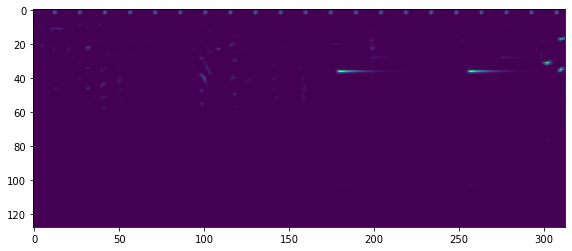

In [77]:
# look at one audio
first_audio_path = DATA_DIR + "/" + metadata.loc[0, "filename"]
audio_1 = librosa.load(first_audio_path, sr=16000)
print(audio_1[0].shape)
plt.figure(figsize=(12, 4))
plt.imshow(librosa.feature.melspectrogram(y=audio_1[0], sr=16000))

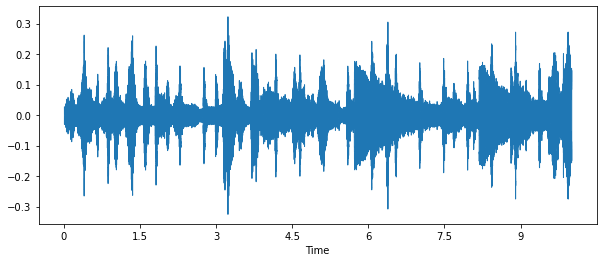

In [78]:
plt.figure(figsize=(10, 4))
display.waveshow(audio_1[0], sr=sr)
ipd.Audio(first_audio_path)

In [18]:
# return both the means of a lot of feature extraction fuctions and the whole melspectrogram outputs 
def extract_features(voice, sample_rate=22050, n_mfcc=40, n_fft=2048):
    
    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=voice, sr=sample_rate, n_mfcc=n_mfcc).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(voice, n_fft=n_fft))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_fft=n_fft).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = librosa.feature.melspectrogram(y=voice, sr=sample_rate, n_fft=n_fft).T
    mel_mean = np.mean(mel, axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate, n_fft=n_fft).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(voice),
    sr=sample_rate).T,axis=0)

    return np.concatenate((mfccs, chroma, mel_mean, contrast, tonnetz), axis=0), mel

In [84]:
shapes = [x.shape for x in extract_features(librosa.load(DATA_DIR + "/" + metadata["filename"][0], sr=sr)[0])]

In [ ]:
# extract features and save it

X_data_mean = np.zeros((len(metadata), shapes[0][0]))
X_data_mel = np.zeros((len(metadata), shapes[1][0], shapes[1][1]))
for i, filename in enumerate(notebook.tqdm(metadata["filename"])):
    X_data_mean[i], mel = extract_features(librosa.load(DATA_DIR + "/" + filename, sr=sr)[0])
    X_data_mel[i, :mel.shape[0]] = mel
    
X_data_mel.tofile("X_data_mel.np")
X_data_mean.tofile("X_data_mean.np")
X_data_mean.shape, X_data_mel.shape

In [85]:
# load saved files with features
X_data_mel = np.fromfile("X_data_mel.np").reshape(len(metadata), shapes[1][0], shapes[1][1])
X_data_mean = np.fromfile("X_data_mean.np").reshape(len(metadata), shapes[0][0])

In [97]:
# split data on train, validation and test paths
X_train, X_test, y_train, y_test = train_test_split(X_data_mel, Y, test_size=0.1, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_train, y_train, test_size=0.5, shuffle=True, random_state=42)

In [100]:
# CRNN parameters getted from sef.yaml

kwargs = {"dropout": 0.5,
  "rnn_layers": 2,
  "n_in_channel": 1,
  "nclass": 10,
  "attention": True,
  "n_RNN_cell": 128,
  "activation": "glu",
  "rnn_type": "BGRU",
  "kernel_size": [3, 3, 3, 3, 3, 3, 3],
  "padding": [1, 1, 1, 1, 1, 1, 1],
  "stride": [1, 1, 1, 1, 1, 1, 1],
  "nb_filters": [ 16, 32, 64, 128, 128, 128, 128 ],
  "pooling": [ [ 2, 2 ], [ 2, 2 ], [ 1, 2 ], [ 1, 2 ], [ 1, 2 ], [ 1, 2 ], [ 1, 2 ] ],
  "dropout_recurrent": 0}

In [102]:
# model = CRNN(cnn_integration=True, n_RNN_cell=128, pooling=[(1, 4), (1, 4), (1, 5)])
model = CRNN(**kwargs)
x = torch.Tensor(X_data_mel[:3])
model(x)

(tensor([[[0.4855, 0.5077, 0.4862,  ..., 0.4836, 0.4956, 0.4816],
          [0.4935, 0.4938, 0.4917,  ..., 0.4888, 0.4796, 0.4766],
          [0.4852, 0.4914, 0.4981,  ..., 0.5019, 0.5094, 0.4954],
          ...,
          [0.5107, 0.5086, 0.4923,  ..., 0.4910, 0.4874, 0.5012],
          [0.5088, 0.4870, 0.5059,  ..., 0.5235, 0.5209, 0.5186],
          [0.4977, 0.5152, 0.4941,  ..., 0.5069, 0.5003, 0.5035]],
 
         [[0.4916, 0.4810, 0.4898,  ..., 0.4659, 0.4906, 0.4939],
          [0.4799, 0.4796, 0.4867,  ..., 0.4861, 0.5021, 0.4991],
          [0.4986, 0.4879, 0.4945,  ..., 0.4959, 0.5145, 0.5131],
          ...,
          [0.5020, 0.4978, 0.4954,  ..., 0.4883, 0.5021, 0.4867],
          [0.5032, 0.4962, 0.5070,  ..., 0.5135, 0.5091, 0.5031],
          [0.5044, 0.5104, 0.4928,  ..., 0.5043, 0.5014, 0.5076]],
 
         [[0.4916, 0.4779, 0.4962,  ..., 0.4964, 0.4818, 0.4845],
          [0.4874, 0.4832, 0.4799,  ..., 0.4889, 0.4852, 0.5048],
          [0.4979, 0.4759, 0.4856,  ...,

In [22]:
import os
for rootdir, dirs, files in os.walk("data/dcase2021/soundbanka/audio/train/soundbank/background"):
    for subdir in dirs:
        _create_symlink(
            os.path.join(rootdir, subdir),
            os.path.join(destination_bg_dir, subdir))

In [ ]:
opt = torch.optim.Adam(sed_student.parameters(), 1e-3, betas=(0.9, 0.999))
exp_steps = config["training"]["n_epochs_warmup"] * epoch_len
exp_scheduler = {
    "scheduler": ExponentialWarmup(opt, config["opt"]["lr"], exp_steps),
    "interval": "step",
}

In [195]:
from DESED_task.desed_task.nnet.CRNN import CRNN
model = CRNN(cnn_integration=True, n_RNN_cell=128, pooling=[(1, 4), (1, 4), (1, 5)])
x = torch.Tensor(X_data_mel[:3])
print(x.size())
x = x.transpose(1, 2).unsqueeze(1)
import warnings

# input size : (batch_size, n_channels, n_frames, n_freq)
if model.cnn_integration:
    bs_in, nc_in = x.size(0), x.size(1)
    x = x.view(bs_in * nc_in, 1, *x.shape[2:])
print("4", x.size())
# conv features
x = model.cnn(x)
print("3", x.size())
bs, chan, frames, freq = x.size()
if model.cnn_integration:
    x = x.reshape(bs_in, chan * nc_in, frames, freq)
print(x.size())
if freq != 1:
    warnings.warn(
        f"Output shape is: {(bs, frames, chan * freq)}, from {freq} staying freq"
    )
    x = x.permute(0, 2, 1, 3)
    x = x.contiguous().view(bs, frames, chan * freq)
    print(x.size())
else:
    x = x.squeeze(-1)
    x = x.permute(0, 2, 1)
x.size()

torch.Size([3, 128, 313])
4 torch.Size([3, 1, 313, 128])
3 torch.Size([3, 64, 313, 1])
torch.Size([3, 64, 313, 1])


torch.Size([3, 313, 64])